# Climate Data Conversion from R to Python using `c4r2d4d`

This notebook illustrates how to use the `c4r2d4d` function to convert climate data from R-based `climate4R` objects into Python's `xarray.Dataset` format for further analysis and manipulation. The function facilitates interoperability between R and Python, allowing users to seamlessly work with climate data in Python.

---

## Table of contents:
*  [Function Overview](#1-bullet)
    * [Parameters and Returns](#1.1-bullet)
    * [Main Steps Involved](#1.2-bullet) 
*  [Example Workflow](#2-bullet)
    *  [Step 1: Loading the R Data](#2.1-bullet)
    *  [Step 2: Applying `c4r2d4d`](#2.2-bullet)
        * [Standard grid](#2.2.1-bullet)
        * [Multi-grid](#2.2.2-bullet)
        * [Station data](#2.2.3-bullet)
        * [Seasonal multi-member data](#2.2.4-bullet)         
    *  [Step 3: Inspecting the Converted Dataset](#2.3-bullet)
*  [Data Visualization](#3-bullet)
*  [Save and Load](#4-bullet)
*  [Benefits of Using `xarray` with Climate Data](#5-bullet)
*  [Conclusions](#6-bullet)
   
## Function Overview <a class="anchor" id="1-bullet"></a>

The `c4r2d4d` function is designed to transform `.Rdata` objects produced by `climate4R` functions into `xarray.Dataset` objects, which can be used with Python's powerful data analysis and visualization libraries. The function extracts key components from the R object, including climate variables, spatial coordinates, time information, and optional metadata. These components are restructured into an `xarray.Dataset` with labeled dimensions and coordinates, ensuring compatibility with Python geospatial libraries.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr


In [2]:
def c4r2d4d(c4r):

    """
    This function transforms a .RData object returned by climate4R functions into an xarray.Dataset for further manipulation and analysis in       Python. It extracts key components from the input R object, such as the variable(s), data, spatial coordinates, temporal information, and optional metadata, and reorganizes them into an xarray.Dataset. The function maps spatial coordinates to longitude (lon) and latitude (lat) for gridded data or assigns them to a loc dimension for flattened datasets. Temporal information is converted into Python's datetime format for easier time-based indexing. The function dynamically handles multiple dimensions, such as time, lat, lon, loc, and member, depending on the structure of the input data. It ensures that the resulting dataset is compatible with Python's geospatial libraries, allowing users to efficiently work with climate data in Python. Additionally, any metadata from the input R object is preserved and included as global attributes in the output xarray.Dataset.

    Parameters
    ----------
    c4r
        The .RData object returned by climate4R functions containing the climate data and metadata.
        

    Returns
    -------
    xr.Dataset 
        The transformed dataset in Python's xarray format, with labeled dimensions and coordinates for easy manipulation and analysis.
    """
    base = importr('base')
    
    # Extract components 
    variable = c4r.rx2('Variable')  
    data = c4r.rx2('Data')  
    xyCoords = c4r.rx2('xyCoords')  
    dates = c4r.rx2('Dates')  
    metadata = c4r.rx2('Metadata') if 'Metadata' in c4r.names else None

    dim_names = base.attr(data, 'dimensions')  
    var_names = list(variable[0])  

    # Convert data to numpy array
    data_array = np.array(data)  

    # Extract coordinates
    lon = np.array(xyCoords.rx2('x'))
    lat = np.array(xyCoords.rx2('y'))

    # Extract time information
    dates_start = np.array(dates.rx2('start') if len(variable.rx2('varName')) == 1 else dates[0].rx2('start'))
    time = pd.to_datetime(dates_start).tz_localize(None)

    # Create dynamic Dataset with the variables involved
    
    data_vars = {}
    loc_x, loc_y = np.array(xyCoords.rx2('x')), np.array(xyCoords.rx2('y'))

    def create_dataset(var_name, dims, data_slice, coords):
        data_vars[var_name] = (dims, data_slice)
        return xr.Dataset(data_vars=data_vars, coords=coords)

    if "var" in dim_names:
        for idx, var_name in enumerate(var_names):
            if "loc" in dim_names:
                if "member" in dim_names:
                    dims = ["member", "time", "loc"]
                    if "Members" in c4r.names:
                        members = seasonal.rx2('Members')
                        new_ds = create_dataset(
                            var_name, dims, data_array[ :, :, :],
                            coords={
                                "lon": ("loc", loc_x),
                                "lat": ("loc", loc_y),
                                "time": ("time", time),
                                "member": ("member", members)
                            }
                        )
                    else:
                        idx_mem = np.where(np.array(dim_names) == 'member')[0][0]
                        new_ds = create_dataset(
                            var_name, dims, data_array[idx, :, :, :],
                            coords={
                                "lon": ("loc", loc_x),
                                "lat": ("loc", loc_y),
                                "time": ("time", time),
                                "member": ("member", np.arange(data_array.shape[idx_mem]))
                            }
                        )
                else:
                    dims = ["time", "loc"]
                    new_ds = create_dataset(
                        var_name, dims, data_array[idx, :, :],
                        coords={
                            "lon": ("loc", loc_x),
                            "lat": ("loc", loc_y),
                            "time": ("time", time)
                        }
                    )
            else:
                if "member" in dim_names:
                    dims = ["member", "time", "lat", "lon"]
                    if "Members" in c4r.names:
                        members = seasonal.rx2('Members')
                        new_ds = create_dataset(
                        var_name, dims, data_array[ :, :, :, :],
                        coords={
                            "lon": ("lon", lon),
                            "lat": ("lat", lat),
                            "time": ("time", time),
                            "member": ("member", members)
                        }
                    )
                    else: 
                        idx_mem = np.where(np.array(dim_names) == 'member')[0][0]
                        new_ds = create_dataset(
                            var_name, dims, data_array[idx, :, :, :, :],
                            coords={
                                "lon": ("lon", lon),
                                "lat": ("lat", lat),
                                "time": ("time", time),
                                "member": ("member", np.arange(data_array.shape[idx_mem]))
                            }
                        )
                else:
                    dims = ["time", "lat", "lon"]
                    new_ds = create_dataset(
                        var_name, dims, data_array[idx, :, :, :],
                        coords={
                            "lon": ("lon", lon),
                            "lat": ("lat", lat),
                            "time": ("time", time)
                        }
                    )
    else:
        if "loc" in dim_names:
            if "member" in dim_names:
                dims = ["member", "time", "loc"]
                if "Members" in c4r.names:
                    members = seasonal.rx2('Members')
                    new_ds = create_dataset(
                        var_name, dims, data_array[ :, :, :, :],
                        coords={
                            "lon": ("loc", loc_x),
                            "lat": ("loc", loc_y),
                            "time": ("time", time),
                            "member": ("member", members)
                        }
                    )
                else:
                    idx_mem = np.where(np.array(dim_names) == 'member')[0][0]
                    new_ds = create_dataset(
                        var_names[0], dims, data_array[:, :, :],
                        coords={
                            "lon": ("loc", loc_x),
                            "lat": ("loc", loc_y),
                            "time": ("time", time),
                            "member": ("member", np.arange(data_array.shape[idx_mem]))
                        }
                    )
            else:
                dims = ["time", "loc"]
                new_ds = create_dataset(
                    var_names[0], dims, data_array[:, :],
                    coords={
                        "lon": ("loc", loc_x),
                        "lat": ("loc", loc_y),
                        "time": ("time", time)
                    }
                )
        else:
            if "member" in dim_names:
                dims = ["member", "time", "lat", "lon"]
                if "Members" in c4r.names:
                    members = seasonal.rx2('Members')
                    new_ds = create_dataset(
                        var_names[0], dims, data_array[:, :, :, :],
                        coords={
                            "lon": ("lon", lon),
                            "lat": ("lat", lat),
                            "time": ("time", time),
                            "member": ("member", members)
                        }
                    )
                else:
                    idx = np.where(np.array(dim_names) == 'member')[0][0]
                    new_ds = create_dataset(
                        var_names[0], dims, data_array[:, :, :, :],
                        coords={
                            "lon": ("lon", lon),
                            "lat": ("lat", lat),
                            "time": ("time", time),
                            "member": ("member", np.arange(data_array.shape[idx_mem]))
                        }
                    )
            else:
                dims = ["time", "lat", "lon"]
                new_ds = create_dataset(
                    var_names[0], dims, data_array[:, :, :],
                    coords={
                        "lon": ("lon", lon),
                        "lat": ("lat", lat),
                        "time": ("time", time)
                    }
                )
                
    # Assign metadata as attributtes if present
    if metadata is not None:
        new_ds.attrs = dict(zip(list(metadata.names), list(metadata)))

        # Assign metadata as attributes
        new_ds.attrs = dict(zip(list(metadata.names), list(metadata)))
 

    return new_ds

### Parameters and Returns <a class="anchor" id="1.1-bullet"></a>

**Parameters**:
- `c4r` (R object): The `.RData` object returned by `climate4R` functions containing the climate data and metadata.

**Returns**:
- `xr.Dataset`: The transformed dataset in `xarray` format, with labeled dimensions and coordinates for easy manipulation and analysis.

---

### Main Steps Involved <a class="anchor" id="1.2-bullet"></a>

1. **Extract Components**: The function extracts key components from the R object, such as the variable(s), data, spatial coordinates, and temporal information.
2. **Handle Dimensions**: The function handles multiple dimensions such as `time`, `lat`, `lon`, `loc`, and `member`, depending on the structure of the input data.
3. **Map Coordinates**: Longitude (`lon`) and latitude (`lat`) are used for gridded data, while a flattened `loc` dimension is used for station-based data.
4. **Convert Time**: Temporal information is converted into Python's `datetime` format, which can be indexed using `pandas` or `xarray`.
5. **Preserve Metadata**: Any additional metadata present in the R object is preserved and added as global attributes to the resulting `xarray.Dataset`.

---

## Example Workflow <a class="anchor" id="2-bullet"></a>

### Step 1: Loading the R Data <a class="anchor" id="2.1-bullet"></a>

Before using the `c4r2py` function, you need to load the `.RData` file containing your climate data. This step depends on using `rpy2` to interface with R objects in Python.

---

In [3]:
robjects.r['load']('data/grid.Rdata')

'grid'


### Step 2: Applying `c4r2d4d` <a class="anchor" id="2.2-bullet"></a>

Once the R data has been loaded, use the `c4r2d4d` function to convert it into an `xarray.Dataset`. Different structures of `climate4R`objects are loaded to show how the function works independently the object dimensions.

---

#### Standard grid <a class="anchor" id="2.2.1-bullet"></a>

Basic climate4R object comprised of time, latitude and longitude dimensions.

In [4]:
grid = robjects.r['grid']
new_grid = c4r2d4d(grid)

print(new_grid)

<xarray.Dataset> Size: 673MB
Dimensions:  (time: 6575, lat: 80, lon: 160)
Coordinates:
  * lon      (lon) float64 1kB -10.0 -9.9 -9.8 -9.7 -9.6 ... 5.5 5.6 5.7 5.8 5.9
  * lat      (lat) float64 640B 36.1 36.2 36.3 36.4 36.5 ... 43.7 43.8 43.9 44.0
  * time     (time) datetime64[ns] 53kB 2000-01-01T12:00:00 ... 2017-12-31T12...
Data variables:
    FWI      (time, lat, lon) float64 673MB nan nan nan ... 0.0006516 0.002278


#### Multi-grid <a class="anchor" id="2.2.2-bullet"></a>

Stack of grids with similar spatiotemporal extents, useful to handle sets of predictors as a single block.

In [5]:
robjects.r['load']('data/multigrid.Rdata')

'mg.hist'


In [6]:
mg = robjects.r['mg.hist']
new_mg = c4r2d4d(mg)

print(new_mg)

<xarray.Dataset> Size: 77MB
Dimensions:  (time: 4018, lat: 14, lon: 34)
Coordinates:
  * lon      (lon) float64 272B -9.75 -9.0 -8.25 -7.5 ... 12.75 13.5 14.25 15.0
  * lat      (lat) float64 112B 35.25 36.0 36.75 37.5 ... 42.75 43.5 44.25 45.0
  * time     (time) datetime64[ns] 32kB 1995-01-01T12:00:00 ... 2005-12-31T12...
Data variables:
    hus850   (time, lat, lon) float64 15MB 0.005384 0.005592 ... 0.004362
    ta850    (time, lat, lon) float64 15MB 277.5 277.6 277.4 ... 273.1 273.3
    tas      (time, lat, lon) float64 15MB 289.6 289.3 289.5 ... 280.4 279.1
    ua850    (time, lat, lon) float64 15MB 1.49 1.711 1.467 ... 7.469 7.749 8.34
    va850    (time, lat, lon) float64 15MB -8.178 -8.269 -7.759 ... 4.819 5.793


#### Station data <a class="anchor" id="2.2.3-bullet"></a>

climate4R object comprise of time and location dimensions.

In [7]:
robjects.r['load']('data/st_prediction.Rdata')

'p'


In [8]:
p = robjects.r['p']
new_st = c4r2d4d(p)
print(new_st)

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 9861, loc: 29)
Coordinates:
    lon      (loc) float64 232B 1.179 -8.411 -8.624 -2.483 ... 2.737 4.216 1.384
    lat      (loc) float64 232B 41.15 42.89 42.24 41.77 ... 39.56 39.85 38.88
  * time     (time) datetime64[ns] 79kB 1985-01-01 1985-01-02 ... 2011-12-31
Dimensions without coordinates: loc
Data variables:
    fwi13    (time, loc) float64 2MB 25.1 1.209 3.88 10.25 ... 21.51 7.239 21.82
Attributes:
    station_id:   [1] "0016A" "1428"  "1495"  "2030"  "2422"  "2614"  "2661" ...
    name:         [1] "REUS-AEROPUERTO"                  "SANTIAGO DE COMPOST...
    altitude:     [1]   71  370  261 1082  735  656  916  790  609  667  628 ...
    provincia:    [1] "TARRAGONA"   "A CORUNA"    "PONTEVEDRA"  "SORIA"      ...


#### Seasonal multi-member data <a class="anchor" id="2.2.4-bullet"></a>

This object present several members where each of them represent a different initialization for the model.

In [9]:
robjects.r['load']('data/seasonal.Rdata')

'seasonal'


In [10]:
seasonal = robjects.r['seasonal']
new_seasonal = c4r2d4d(seasonal)
print(new_seasonal)

<xarray.Dataset> Size: 124MB
Dimensions:  (member: 25, time: 215, lat: 40, lon: 72)
Coordinates:
  * lon      (lon) float64 576B -20.0 -19.0 -18.0 -17.0 ... 48.0 49.0 50.0 51.0
  * lat      (lat) float64 320B 14.0 15.0 16.0 17.0 18.0 ... 50.0 51.0 52.0 53.0
  * time     (time) datetime64[ns] 2kB 1981-01-01 1981-01-02 ... 1981-08-03
  * member   (member) <U2 200B '0' '1' '2' '3' '4' ... '20' '21' '22' '23' '24'
Data variables:
    hurs     (member, time, lat, lon) float64 124MB 67.19 63.66 ... 64.73 65.68


### Step 3: Inspecting the Converted Dataset <a class="anchor" id="2.3-bullet"></a>

After the conversion, inspect he structure of the resulting `xarray.Dataset` to ensure that the data has been correctly transformed, with proper dimensions and coordinates.

---

First, we check the coordinates and data variables from the standard grid dataset

In [11]:
print(new_grid.coords)

Coordinates:
  * lon      (lon) float64 1kB -10.0 -9.9 -9.8 -9.7 -9.6 ... 5.5 5.6 5.7 5.8 5.9
  * lat      (lat) float64 640B 36.1 36.2 36.3 36.4 36.5 ... 43.7 43.8 43.9 44.0
  * time     (time) datetime64[ns] 53kB 2000-01-01T12:00:00 ... 2017-12-31T12...


In [12]:
print(new_grid.data_vars)

Data variables:
    FWI      (time, lat, lon) float64 673MB nan nan nan ... 0.0006516 0.002278


Since multigrids stack several variables, we take a look to the variables available in the multigrid object

In [13]:
print(new_mg.data_vars)

Data variables:
    hus850   (time, lat, lon) float64 15MB 0.005384 0.005592 ... 0.004362
    ta850    (time, lat, lon) float64 15MB 277.5 277.6 277.4 ... 273.1 273.3
    tas      (time, lat, lon) float64 15MB 289.6 289.3 289.5 ... 280.4 279.1
    ua850    (time, lat, lon) float64 15MB 1.49 1.711 1.467 ... 7.469 7.749 8.34
    va850    (time, lat, lon) float64 15MB -8.178 -8.269 -7.759 ... 4.819 5.793


We can access a specific variable (in this case 'tas') and inspect it from the list of available variables shown in the previous cell.

In [14]:
print(new_mg['tas'])

<xarray.DataArray 'tas' (time: 4018, lat: 14, lon: 34)> Size: 15MB
array([[[289.56469727, 289.33517456, 289.48468018, ..., 288.5222168 ,
         289.07611084, 289.45501709],
        [289.38430786, 289.347229  , 289.16842651, ..., 289.41473389,
         289.3500061 , 289.63674927],
        [289.38226318, 289.12658691, 289.09185791, ..., 289.53375244,
         289.45458984, 288.77194214],
        ...,
        [287.27706909, 286.73400879, 284.81503296, ..., 284.43463135,
         285.29449463, 285.60125732],
        [287.10839844, 287.08123779, 286.90817261, ..., 284.8822937 ,
         285.30834961, 284.95983887],
        [286.96188354, 286.85961914, 286.91482544, ..., 283.24493408,
         280.81509399, 280.32635498]],

       [[288.9079895 , 288.92242432, 288.88845825, ..., 288.80993652,
         288.650177  , 288.58566284],
        [289.18615723, 288.96539307, 288.93844604, ..., 288.87359619,
         288.59924316, 288.72314453],
        [289.60525513, 289.34667969, 289.15777588, ...

Checking the time range of the dataset is also important

In [15]:
print(new_mg.time.min())
print(new_mg.time.max())

<xarray.DataArray 'time' ()> Size: 8B
array('1995-01-01T12:00:00.000000000', dtype='datetime64[ns]')
<xarray.DataArray 'time' ()> Size: 8B
array('2005-12-31T12:00:00.000000000', dtype='datetime64[ns]')


We can easily plot a variable (e.g., *tas* ), resulting in a barplot showing the distribution of our data.

(array([6.70000e+01, 7.74000e+02, 7.46500e+03, 6.86640e+04, 2.38308e+05,
        5.21542e+05, 6.69880e+05, 3.71739e+05, 3.20160e+04, 2.11300e+03]),
 array([252.47599792, 258.19507904, 263.91416016, 269.63324127,
        275.35232239, 281.0714035 , 286.79048462, 292.50956573,
        298.22864685, 303.94772797, 309.66680908]),
 <BarContainer object of 10 artists>)

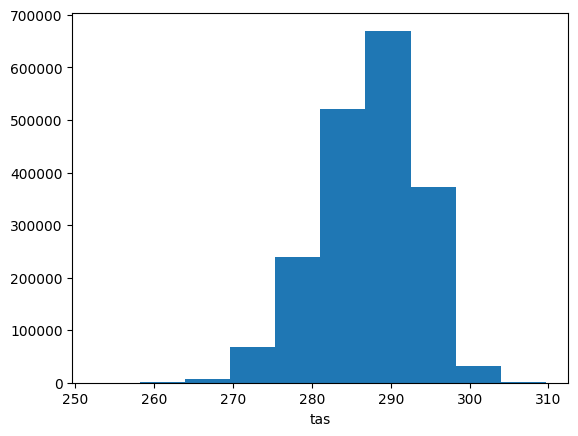

In [16]:
new_mg['tas'].plot()

We can also check the presence (or not) of missing data in the variables comprising the multigrid

In [17]:
print(new_mg.isnull().sum())

<xarray.Dataset> Size: 40B
Dimensions:  ()
Data variables:
    hus850   int64 8B 0
    ta850    int64 8B 0
    tas      int64 8B 0
    ua850    int64 8B 0
    va850    int64 8B 0


Selecting data for a specific date is also possible

In [18]:
new_grid.FWI.sel(time="2016-08-01")

<xarray.DataArray 'FWI' (time: 1, lat: 80, lon: 160)> Size: 102kB
array([[[        nan,         nan,         nan, ..., 59.30397415,
         68.48465729, 80.35691833],
        [        nan,         nan,         nan, ..., 57.36981201,
         66.59973145, 78.35696411],
        [        nan,         nan,         nan, ..., 64.06666565,
         69.86888123, 76.28874969],
        ...,
        [        nan,         nan,         nan, ..., 59.4197731 ,
         65.760849  , 77.36585999],
        [        nan,         nan,         nan, ..., 44.33742523,
         50.73013306, 60.25685501],
        [        nan,         nan,         nan, ..., 29.74465561,
         36.47755814, 46.96414185]]])
Coordinates:
  * lon      (lon) float64 1kB -10.0 -9.9 -9.8 -9.7 -9.6 ... 5.5 5.6 5.7 5.8 5.9
  * lat      (lat) float64 640B 36.1 36.2 36.3 36.4 36.5 ... 43.7 43.8 43.9 44.0
  * time     (time) datetime64[ns] 8B 2016-08-01T12:00:00

The attributes are also present in the transformation, since this information is sometimes useful as in the case of station ID codes

In [19]:
new_st.attrs['station_id']

'0016A','1428','1495',...,'B278','B893','B954'


## Data Visualization <a class="anchor" id="3-bullet"></a>

Here, we present the spatial information from the *new_grid* (standard grid) object using a series of basic plots.

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

First, we calculate the climatology of our data just performing the mean operation over the time dimension. Therefore, in just one line we show the spatial climatology of the Fire Weather Index (FWI) over the Iberian Peninsula from 2018 to 2022.

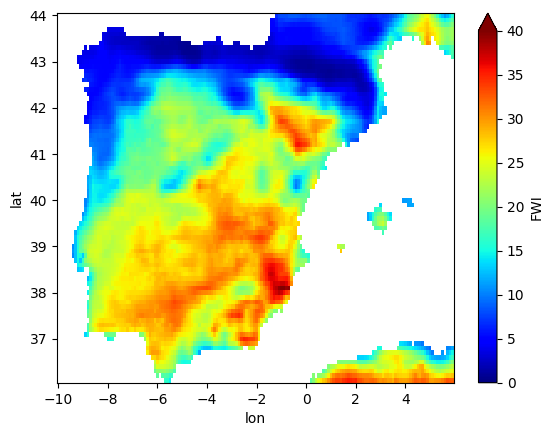

In [21]:
ax = new_grid.FWI.mean(dim = "time").plot(vmin=0, vmax=40, cmap="jet")

With cartopy we can improve our plots adding projections, geographic limits or feature caracteristics (countries, states). Here we plot the FWI for a certain day over the Iberian Peninsula adding layers from borders and states from the Iberian countries.

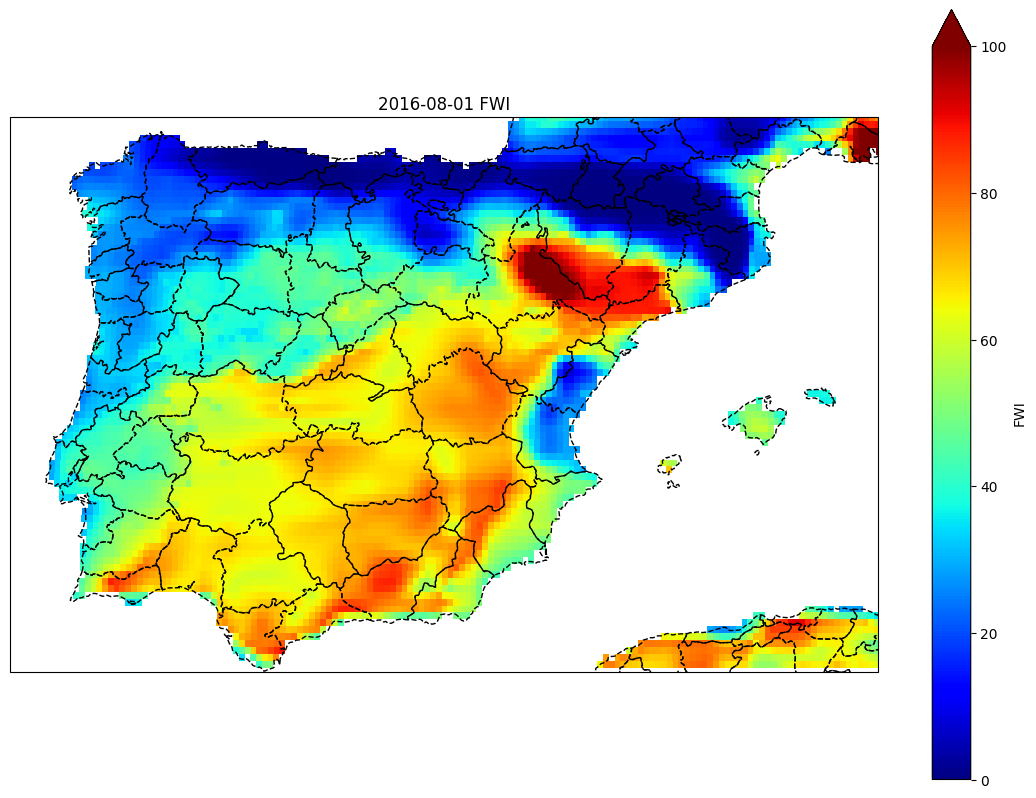

In [22]:
variable = new_grid['FWI'].sel(time = "2016-08-01")
lon = variable.lon
lat = variable.lat

# Define lon lat limits
lon_min, lon_max = -10, 5
lat_min, lat_max = 36, 44


#Set up figure and axis using Cartopy
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.Robinson())

# Variable plot
im = variable.plot(ax=ax, cmap="jet", transform=ccrs.PlateCarree(), vmin = 0, vmax = 100)

# Add Iberian Peninsula limits
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add additional features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='--')

fwi_date = str(variable.time.values).split('T')[0].split("['")[1]
# Title and axis labels
plt.title(f'{fwi_date} FWI')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Show the plot
plt.show()

## Save and Load <a class="anchor" id="4-bullet"></a>

We save the converted .Rdata as a NetCDF file and then verify the file by opening it.

In [23]:
new_grid.to_netcdf('data/my_grid.nc')

In [25]:
xr.open_dataset('data/my_grid.nc')

<xarray.Dataset> Size: 673MB
Dimensions:  (time: 6575, lat: 80, lon: 160)
Coordinates:
  * lon      (lon) float64 1kB -10.0 -9.9 -9.8 -9.7 -9.6 ... 5.5 5.6 5.7 5.8 5.9
  * lat      (lat) float64 640B 36.1 36.2 36.3 36.4 36.5 ... 43.7 43.8 43.9 44.0
  * time     (time) datetime64[ns] 53kB 2000-01-01T12:00:00 ... 2017-12-31T12...
Data variables:
    FWI      (time, lat, lon) float64 673MB ...

## Benefits of Using `xarray` with Climate Data <a class="anchor" id="5-bullet"></a>

- **Multi-dimensional Arrays**: `xarray` allows for easy handling of multi-dimensional climate data (e.g., time, latitude, longitude, and ensemble members).
- **Time-Based Indexing**: With `xarray`, you can index and manipulate climate data based on time, which is particularly useful for time series analysis.
- **Efficient Data Access**: `xarray` makes it easy to select, slice, and aggregate data in a way that scales well with large datasets.

---

## Conclusions <a class="anchor" id="6-bullet"></a>

The `c4r2d4d` function provides a straightforward way to convert climate data from R to Python, enabling users to leverage Python's scientific libraries for further analysis and visualization. By converting data into `xarray.Dataset` format, it ensures compatibility with tools like `matplotlib`, `cartopy`, and `pandas` for advanced data manipulation and visualization.

For more information, refer to the official `xarray` documentation: [xarray Documentation](http://xarray.pydata.org/).